In [ ]:
import pandas as pd
import pandas.api.types as pdtypes
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict
import re
import pickle

In [ ]:
# !pip install langchain==0.3.11
# !pip install langchain-community==0.3.11
# !pip install langchain-google-genai google-generativeai

In [ ]:
file = './ds_assignment_data.csv'
data= pd.read_csv(file)
print(f'data has {data.shape[0]} rows and {data.shape[1]} features')

data has 10000 rows and 157 features


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Columns: 157 entries, int_date to clinical_sheet
dtypes: float64(95), int64(61), object(1)
memory usage: 12.0+ MB


In [ ]:
df= data.copy()

In [ ]:
def prepare_target_data(df):
  """
  prepare target data:
  We utilize the ground-truth information to rank the severity of each record.
  Specifically, we associate each record with a class:
  0 - No Hypertention
  1 - Gestational Hypertension
  2 - Preeclampsia
  3 - Eclampsia (mostr severe)
  """
  source_indicators = [col for col in df.columns if col.startswith('match')]
  # we add one column to the df
  df['Hypertension_severity'] = df['Y']
  df['Hypertension_severity']  = np.where(df['pregnancy_hypertension_sum'] > 0, 1, df['Hypertension_severity'])
  df['Hypertension_severity'] = np.where(df['preeclampsia_sum'] > 0, 2, df['Hypertension_severity'])
  df['Hypertension_severity'] = np.where(df['eclampsia_sum'] > 0, 3, df['Hypertension_severity'])
  df['Hypertension_severity'] = df['Hypertension_severity'].astype(int)
  return df

In [ ]:
df= prepare_target_data(df)
print(f'numer of rows:{df.shape[0]},number of columns : {df.shape[1]}')


numer of rows:10000,number of columns : 158


In [ ]:
def plot_target_distribution(data,target_col):
 count_target = data[target_col].value_counts()
 percentages = data[target_col].value_counts(normalize= True)*100

# Create bar plot
 plt.figure(figsize=(8, 5))
 ax = sns.barplot(x=count_target.index, y=count_target.values)
                  #palette='pastel')

# Add percentages on top
 for i, (count, pct) in enumerate(zip(count_target, percentages,)):
    ax.text(i, count - 0.4, f'{pct:.1f}%\n{count}', ha='center', va='bottom', fontsize=12)

# Formatting
 plt.title('Target Distribution with Percentages', fontsize=14)
 plt.ylabel('Count')
 plt.xlabel('Category')
 sns.despine()

 plt.tight_layout()
 plt.savefig('target_distribution.png', dpi=300)
 plt.show()
 plt.close()

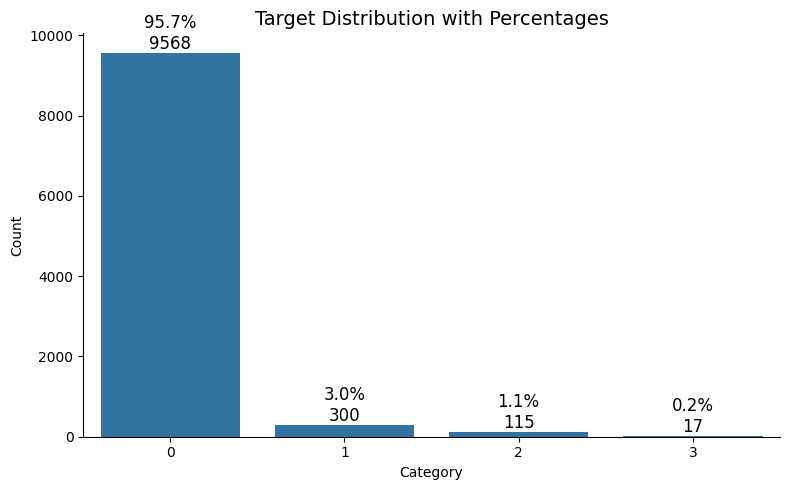

In [ ]:
target_col = 'Hypertension_severity'
plot_target_distribution(df,target_col)

In [ ]:
def remove_null_columns(df,processing_data,threshlod=0.7):

  # accept df and return all columns with null percentage above threshold
  null_precentages = df.isnull().mean()
  null_precentages = null_precentages[null_precentages>threshlod]
  print(f'{len(null_precentages.index)} have null rate higher than {threshlod}')
  processing_data['null_columns'] = null_precentages.index
  return null_precentages.index,processing_data

In [ ]:
def remove_low_var_columns(data,processing_data,threshlod=0):

  # accept df and return all columns with variance bellow threshold
  x = data.select_dtypes(exclude=['object']).var()
  if threshlod==0:
    low_variance_columns = x[x==0].index
  else:
    low_variance_columns = x[x<=threshlod].index
  print(f'{len(low_variance_columns)} have variance of rate equal or lower than {threshlod}')
  processing_data['low_variance_columns'] =  low_variance_columns
  return low_variance_columns,processing_data

In [ ]:
def get_correlated_features(df,proecessing_data,target_col ='Hypertension_severity' ,threshold = 0.9):

  # accept df and return all columns with correlation coefficient above threshold
  correlated_features = defaultdict(list)
  correlated_values_to_discard = set()
  sub_df = df.select_dtypes(exclude=['object'])
  features_df = sub_df.drop(columns = target_col,axis=1)
  corr_matrix = features_df.corr().abs()
  upper = corr_matrix.where(
    np.triu(np.ones(corr_matrix.shape), k=1).astype(bool)
  )

  # search for highly correlated features
  rows = upper.index
  columns = corr_matrix.columns
  for row in rows:
    for column in columns:
      if row != column:
        if upper.loc[row,column] >=threshold:
          correlated_features[row].append(column)

  for value in correlated_features.values():
    correlated_values_to_discard.update(value)
    proecessing_data['high_correlated_features'] = correlated_values_to_discard

  print(f'{len(correlated_values_to_discard)} have correlation rate with other features higher than {threshold}')
  return list(correlated_values_to_discard),proecessing_data,correlated_features

In [ ]:
#preprocessing
def preprocessing(df,processing_data):

  #remove int_date as provide to information
  df.drop('int_date',axis=1,inplace=True)
  source_indicators = [col for col in df.columns if col.startswith('match')]
  columns_to_drop =  source_indicators+['Y']+[col for col in df.columns if '_sum'  in col]
  df.drop(columns = columns_to_drop,axis=1,inplace=True)

  ## checkinh null values
  null_value_columns,processing_data = remove_null_columns(df,processing_data)
  df.drop(columns = null_value_columns,axis=1,inplace=True)
  low_variance_columns,processing_data = remove_low_var_columns(df,processing_data)
  df.drop(columns = low_variance_columns,axis=1,inplace=True)
  correlated_values_to_discard,processing_data,correlated_features= get_correlated_features(df,processing_data)
  df.drop(columns = correlated_values_to_discard,axis=1,inplace=True)
  return df,processing_data,correlated_features

In [ ]:
# prepocessing the features
processing_data = {} # backlog of features that were omitted and the reason for that
df,processing_data,correlated_features = preprocessing(df,processing_data)

45 have null rate higher than 0.7
1 have variance of rate equal or lower than 0
16 have correlation rate with other features higher than 0.9


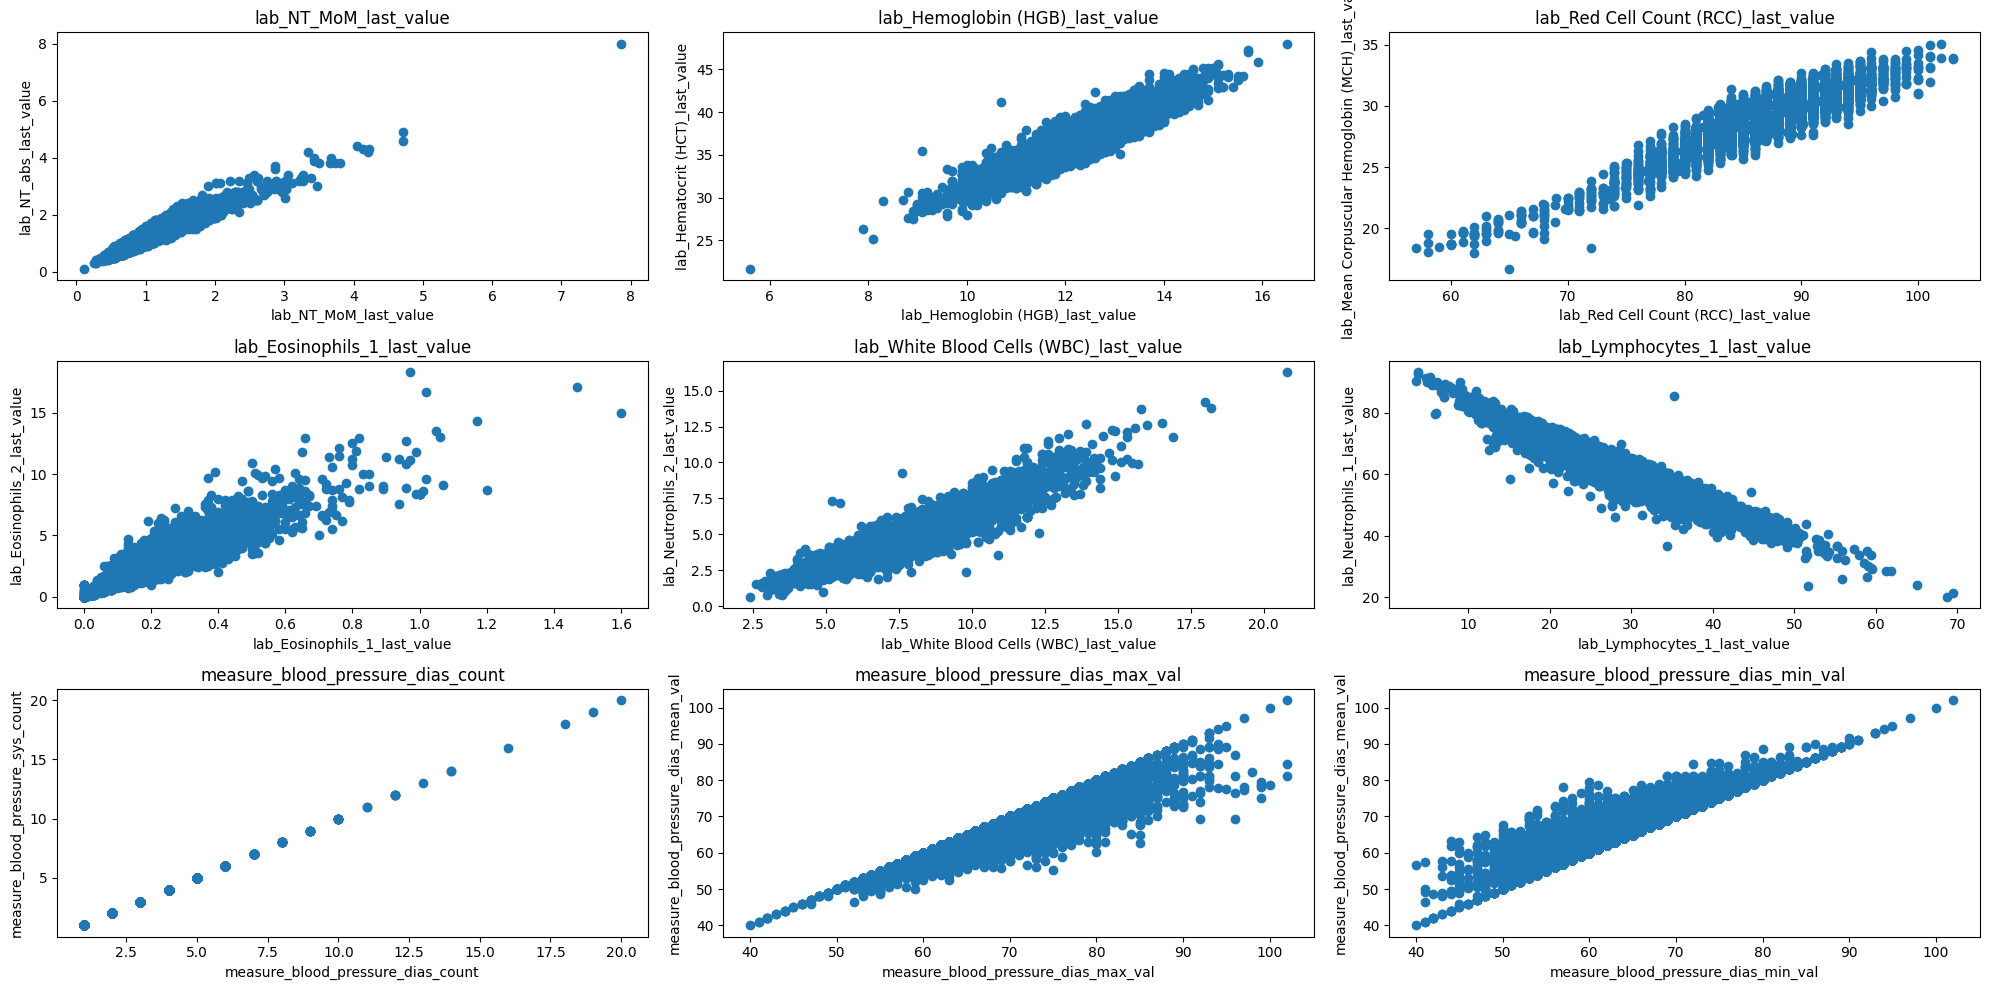

In [ ]:
def plot_features(data,correlated_dic,num_features=10):
  ncols = 3
  nrows = int(np.ceil(num_features)/ncols)
  fig,axes = plt.subplots(nrows=nrows,ncols=ncols,figsize=(20,10))
  axes = axes.flatten()
  features = list(correlated_dic.keys())[:num_features]
  for ax,feat in zip(axes,features):
    value = correlated_dic[feat][0]
    ax.scatter(data[feat],data[value])
    ax.set_title(feat)
    ax.set_xlabel(feat)
    ax.set_ylabel(value)
  plt.tight_layout()
  plt.savefig('correlated_features.png', dpi=300)
  plt.show()
  plt.close()

# example of higly correlated features (0.9)
plot_features(data,correlated_features)

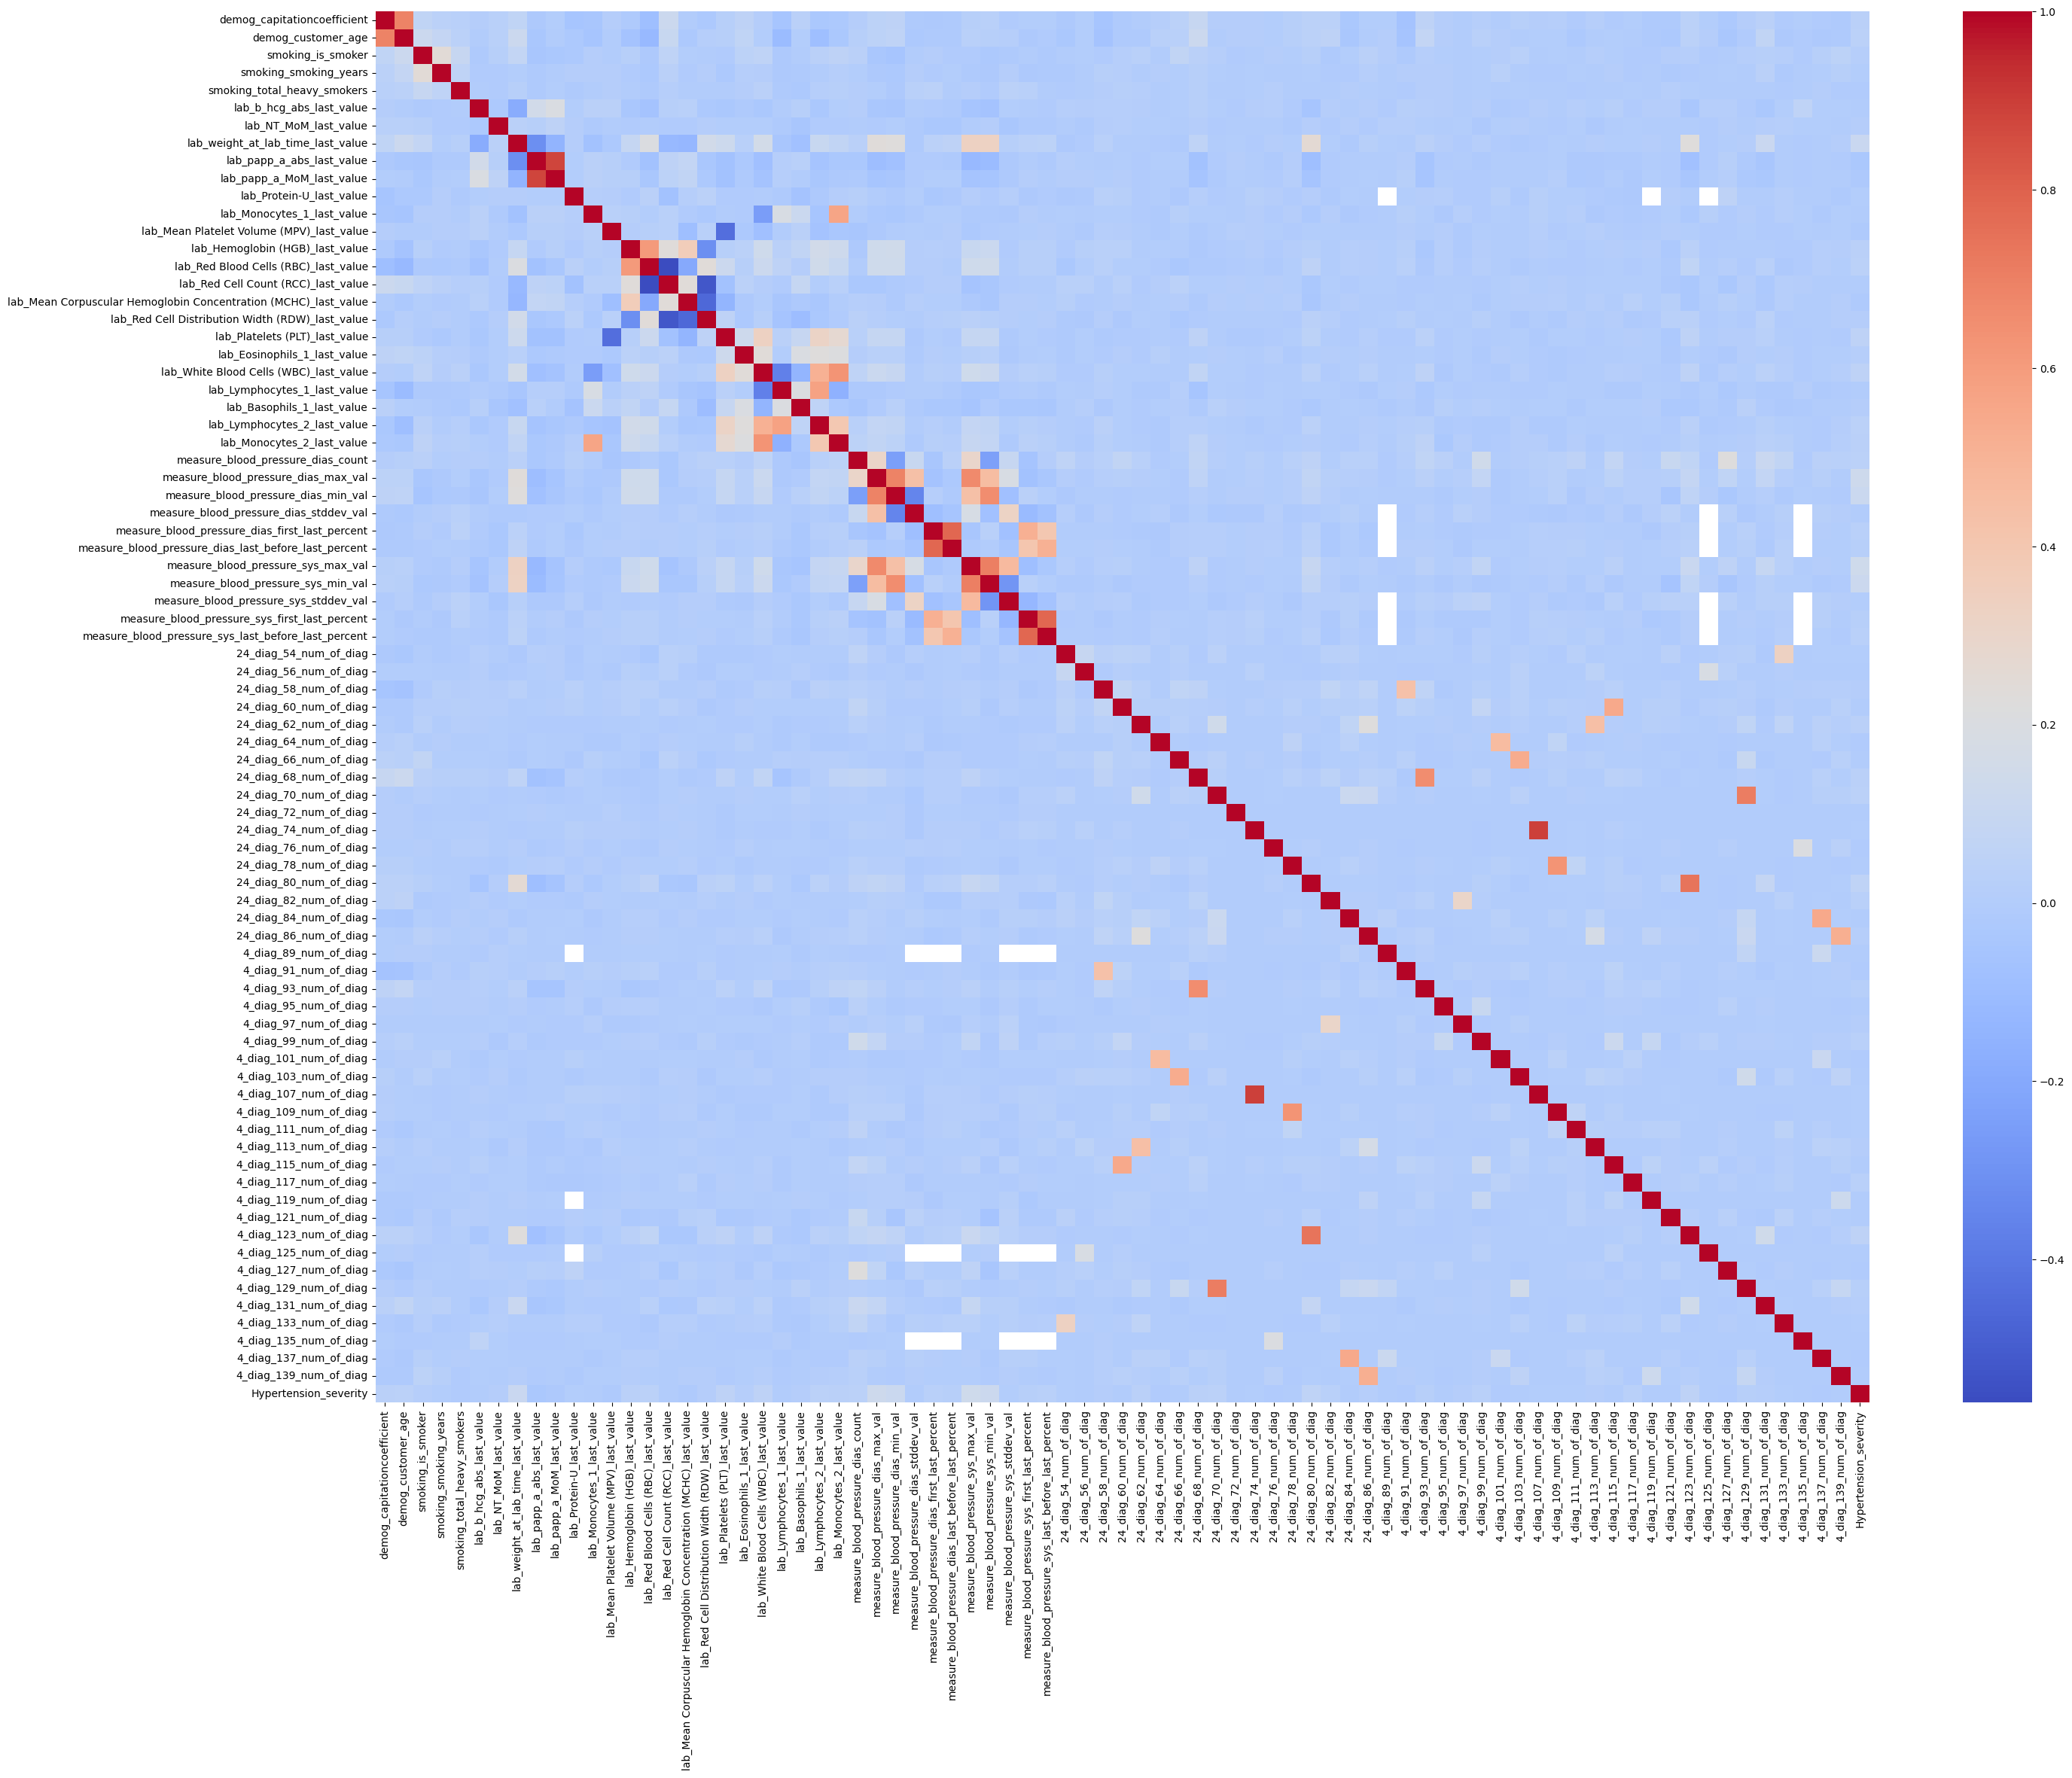

In [ ]:
# findng correlatation:
corr_matrix =df.select_dtypes(exclude=['object']).corr()
fig = plt.figure(figsize=(6.4*5, 4.8*5))
sns.heatmap(corr_matrix,annot=False,cmap='coolwarm')
# plt.tight_layout()
size = fig.get_size_inches()
plt.savefig('correlation_matrix.png', dpi=400)
plt.show()
plt.close()

In [ ]:
def plot_categorical_varible(df,col,target_col):

  cross = pd.crosstab(df[col], df[target_col], normalize='index')
  sns.set_theme(style="whitegrid")
  sns.set_palette(["#0072B2", "#D55E00"])
  sns.set_theme(style="whitegrid")
  colors = ["#2C7BB6", "#FDAE61", "#ABD9E9", "#D7191C"]
  cross.plot(
      kind="bar",
      stacked=True,
      color=colors,
      figsize=(8, 5),
      edgecolor='black'
  )
  plt.title(f"Target Distribution by {col} Category", fontsize=14)
  plt.xlabel(f"{col}", fontsize=12)
  plt.ylabel("Proportion", fontsize=12)
  plt.xticks(rotation=0, fontsize=10)
  plt.yticks(fontsize=10)
  plt.legend(title="Target Variable", title_fontsize=11, fontsize=10, loc='upper right')
  plt.tight_layout()

  plt.savefig(f'{col}_distribution.png', dpi=300)
  plt.show()
  plt.close()

In [ ]:
def plot_continuous_varible(df, float_features,target_col):
 for feature in float_features:
    sns.set_theme(style="whitegrid", palette="pastel")
    sns.kdeplot(data=df, x=feature, hue=target_col, common_norm=False, fill=True, alpha=0.4)
    plt.xlabel(feature)
    plt.ylabel("Density (per class)")
    plt.savefig(f'{feature}_distribution.png', dpi=300)
    plt.show()
    plt.close()

In [ ]:
def feature_target_correlation(df,target_col,num_features = 5):
  x =df.select_dtypes(exclude=['object'])
  corr_matrix = x.corr()
  target_col = 'Hypertension_severity'
  features =list( corr_matrix[target_col].sort_values(ascending=False).head(num_features+1).index)[1:]
  float_features = x[features ].select_dtypes(include=['float']).columns
  int_features = x[features].select_dtypes(include=['int']).columns
  plot_continuous_varible(df, float_features,target_col)
  #for feature in int_features:
   # plot_categorical_varible(df,feature,target_col)

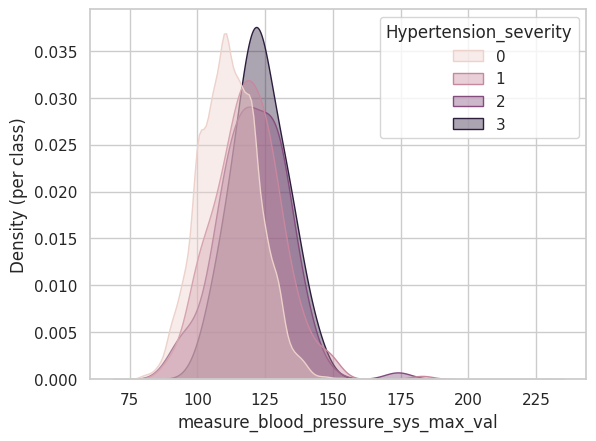

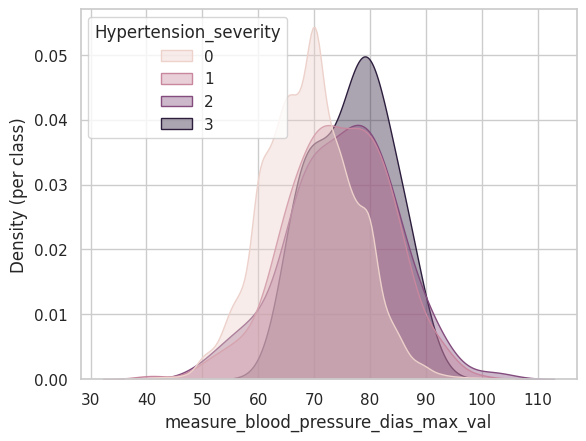

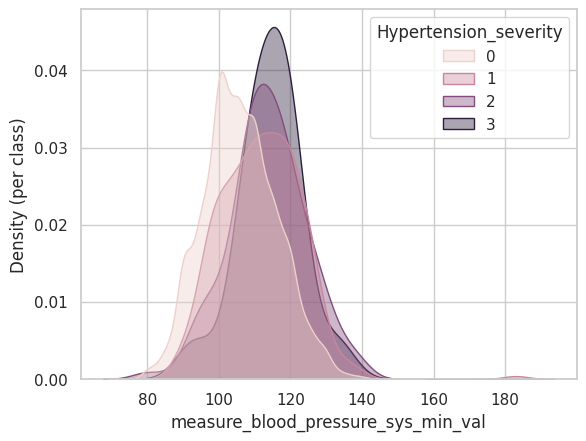

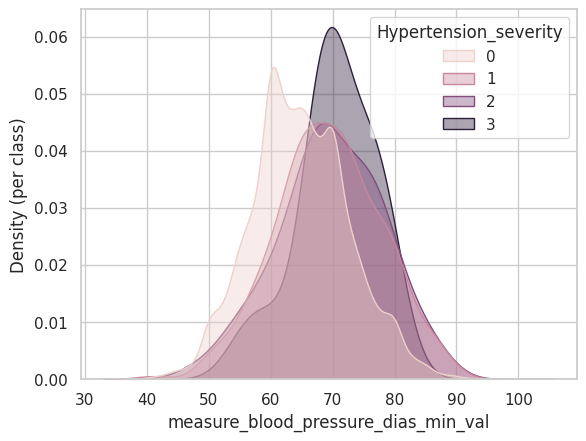

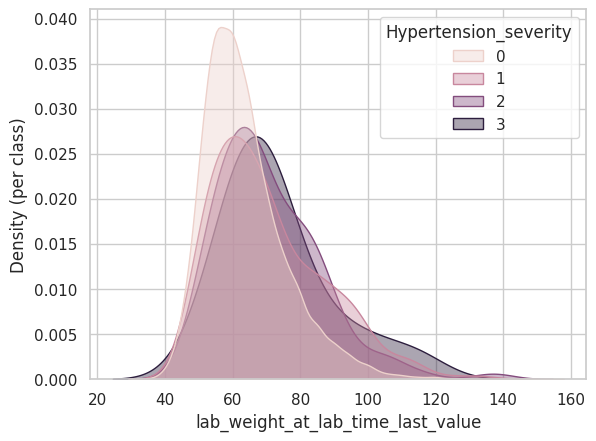

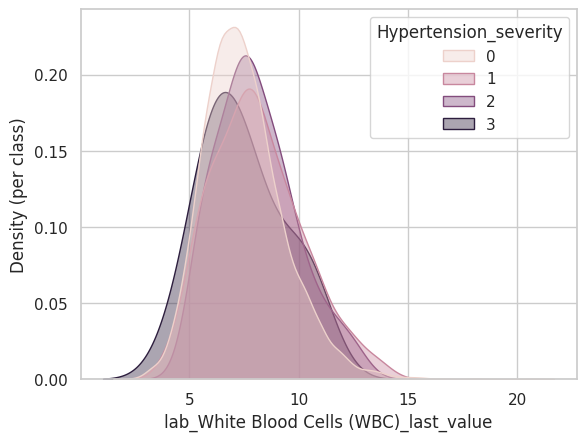

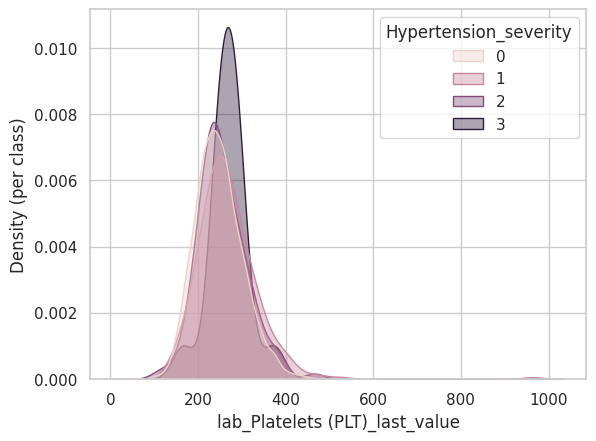

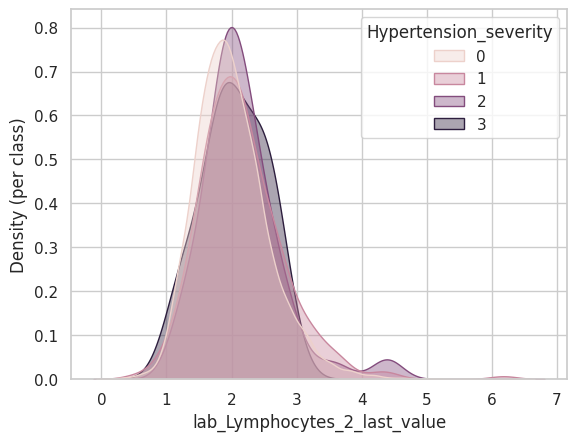

In [ ]:
feature_target_correlation(df,target_col='Hypertension_severity',num_features = 10)

In [ ]:
'''
def get_medical_pharses(text,medical_phrases):
  matches = re.findall(r"[^\[\]'\"]+", text)
  if matches:
    for match in matches:
            if match.strip() and match.strip() != ',':
               x= match.strip()
               medical_phrases.append(x)
  return medical_phrases
  '''

'\ndef get_medical_pharses(text,medical_phrases):\n  matches = re.findall(r"[^\\[\\]\'"]+", text)\n  if matches:\n    for match in matches:\n            if match.strip() and match.strip() != \',\':\n               x= match.strip()\n               medical_phrases.append(x)\n  return medical_phrases\n  '

In [ ]:
'''
from langchain_google_genai import ChatGoogleGenerativeAI
# The puprose of this code is to build a dictionary of risk factors from the clinicl sheets.
# These risk factors will be used as additional feautres
# The dictionary file is provided, no need to run this code
Google_Key = 'your_google_key'
model = 'models/gemma-3-27b-it'

llm = ChatGoogleGenerativeAI(model = model,google_api_key= Google_Key,temprature = 0)
from langchain_core.prompts import ChatPromptTemplate
medical_phrases = []

prompt_txt = """
Analyze the following Hebrew clinical notes and list all identified risk factors.
    For each risk factor found, output its standardized hebrew name (e.g., 'עישון', 'סכרת', 'לחץ דם') only with out additional data.
    Do not include any risk factors that are explicitly stated as absent or are not mentioned.
    If no risk factors are mentioned as present, return an empty array [].


 {topic}

 """
prompt = ChatPromptTemplate.from_template(prompt_txt)



llm_chain = (
    prompt
      |
    llm
)
texts = df['clinical_sheet'].to_list()
for text in texts:
  response = llm_chain.invoke({"topic": text})
  medical_phrases = get_medical_pharses(response.content,medical_phrases)

# medical_phrases_unique = list(set(medical_phrases))
# medical_phrases_unique=[word for word in medical_phrases_unique if word!= 'preeclampsia']
# import pickle
# with open('medical_phrases', 'wb') as file:
#   pickle.dump(medical_phrases_unique, file)
'''

'\nfrom langchain_google_genai import ChatGoogleGenerativeAI\n# The puprose of this code is to build a dictionary of risk factors from the clinicl sheets.\n# These risk factors will be used as additional feautres\n# The dictionary file is provided, no need to run this code\nGoogle_Key = \'your_google_key\'\nmodel = \'models/gemma-3-27b-it\'\n\nllm = ChatGoogleGenerativeAI(model = model,google_api_key= Google_Key,temprature = 0)\nfrom langchain_core.prompts import ChatPromptTemplate\nmedical_phrases = []\n\nprompt_txt = """\nAnalyze the following Hebrew clinical notes and list all identified risk factors.\n    For each risk factor found, output its standardized hebrew name (e.g., \'עישון\', \'סכרת\', \'לחץ דם\') only with out additional data.\n    Do not include any risk factors that are explicitly stated as absent or are not mentioned.\n    If no risk factors are mentioned as present, return an empty array [].\n\n\n {topic} \n\n """\nprompt = ChatPromptTemplate.from_template(prompt_txt

In [ ]:
with open('medical_phrases', 'rb') as file:
  risk_factors = pickle.load(file)

In [ ]:
# in this section for each customer we search for risk factors appearing in the clinical sheet
with open('medical_phrases', 'rb') as file:
  risk_factors = pickle.load(file)

risk_factors_features = {f'risk_factor_feature_{i}':value for i, value in enumerate(risk_factors)}

def extract_risk_factors_from_text(df,risk_factors):
  texts = df['clinical_sheet'].to_list()

  for feature in risk_factors_features.keys ():
      df[feature] = 0

  for i, text in enumerate(texts):
      for key, phrase in risk_factors_features.items():
          if re.search(re.escape(phrase), text):
              df.at[i, key] = 1
  df.drop('clinical_sheet',axis=1,inplace=True)
  return df

df = extract_risk_factors_from_text(df,risk_factors)

In [ ]:
df[risk_factors_features.keys()].info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 18 columns):
 #   Column                  Non-Null Count  Dtype
---  ------                  --------------  -----
 0   risk_factor_feature_0   10000 non-null  int64
 1   risk_factor_feature_1   10000 non-null  int64
 2   risk_factor_feature_2   10000 non-null  int64
 3   risk_factor_feature_3   10000 non-null  int64
 4   risk_factor_feature_4   10000 non-null  int64
 5   risk_factor_feature_5   10000 non-null  int64
 6   risk_factor_feature_6   10000 non-null  int64
 7   risk_factor_feature_7   10000 non-null  int64
 8   risk_factor_feature_8   10000 non-null  int64
 9   risk_factor_feature_9   10000 non-null  int64
 10  risk_factor_feature_10  10000 non-null  int64
 11  risk_factor_feature_11  10000 non-null  int64
 12  risk_factor_feature_12  10000 non-null  int64
 13  risk_factor_feature_13  10000 non-null  int64
 14  risk_factor_feature_14  10000 non-null  int64
 15  risk_factor_feature_

In [ ]:
## checking outliers
def plot_outliers_distribution(df,features,ncols=3):

 #
 nrows = int(np.ceil(len(features)/ncols))
 fig,axes = plt.subplots(nrows=nrows,ncols=3,figsize=(20,10))
 axes = axes.flatten()
 for ax,feat in zip(axes,features):
    ax.hist(df[feat],bins =10)
    ax.set_title(feat)
    ax.set_xlabel('Value')
    ax.set_ylabel('Frequency')
 plt.tight_layout()
 plt.show()


In [ ]:
# using SMOTE
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_validate
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import make_scorer, accuracy_score, precision_score, recall_score, f1_score
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

X = df.drop(['Hypertension_severity'], axis=1)
y = df['Hypertension_severity']


X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# Create a pipeline: SMOTE + Classifier
pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')),
    ('smote', SMOTE(random_state=42)),
    ('clf', RandomForestClassifier( n_estimators = 100,class_weight='balanced',min_samples_split =20,max_depth=5,random_state=42))
])
# Define scoring metrics
scoring = {
    'accuracy': make_scorer(accuracy_score),
    'precision_macro': make_scorer(precision_score, average='macro', zero_division=0),
    'recall_macro': make_scorer(recall_score, average='macro', zero_division=0),
    'f1_macro': make_scorer(f1_score, average='macro', zero_division=0),
}

# Define cross-validation strategy
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Run cross-validation
cv_results = cross_validate(
    pipeline, X_train, y_train,
    cv=cv,
    scoring=scoring,
    return_train_score=True
)

# Print average train/test scores to find over fitting
print("Cross-validation results (on training set):")
for metric in scoring.keys():
    print(f"{metric}:")
    print(f"  Train: {cv_results[f'train_{metric}'].mean():.3f} ± {cv_results[f'train_{metric}'].std():.3f}")
    print(f"  Test : {cv_results[f'test_{metric}'].mean():.3f} ± {cv_results[f'test_{metric}'].std():.3f}")



Cross-validation results (on training set):
accuracy:
  Train: 0.942 ± 0.002
  Test : 0.931 ± 0.005
precision_macro:
  Train: 0.483 ± 0.012
  Test : 0.336 ± 0.021
recall_macro:
  Train: 0.676 ± 0.014
  Test : 0.358 ± 0.039
f1_macro:
  Train: 0.533 ± 0.013
  Test : 0.340 ± 0.025


In [ ]:
def display_metrics(y_true, y_pred,mode = 'train'):
   cm = confusion_matrix(y_true, y_pred)
   cm_percent = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

   labels = []
   for i in range(cm.shape[0]):
        row = []
        for j in range(cm.shape[1]):
            count = cm[i, j]
            percent = cm_percent[i, j] * 100
            row.append(f"{percent:.1f}%\n{count}")
        labels.append(row)
   plt.figure(figsize=(6, 5))
   sns.heatmap(cm_percent, annot=labels, fmt='', cmap='Blues', cbar=False,
                xticklabels=np.unique(y_true), yticklabels=np.unique(y_true))
   plt.xlabel('Predicted Label')
   plt.ylabel('True Label')
   plt.title(f'{mode} confusion matrix')
   plt.tight_layout()
   plt.savefig(f'{mode}_confusion_matrix.png', dpi=300)
   plt.show()
   plt.close()


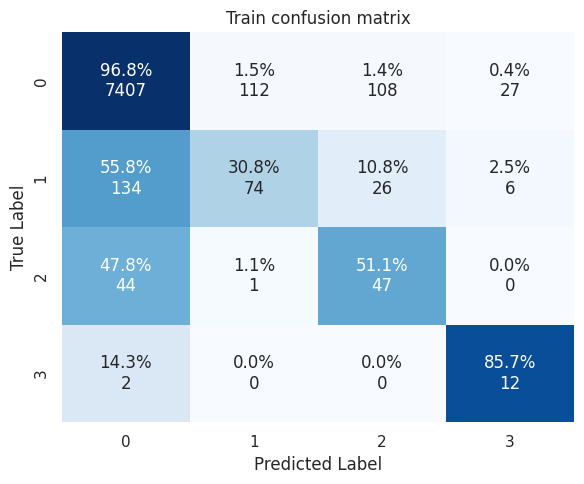

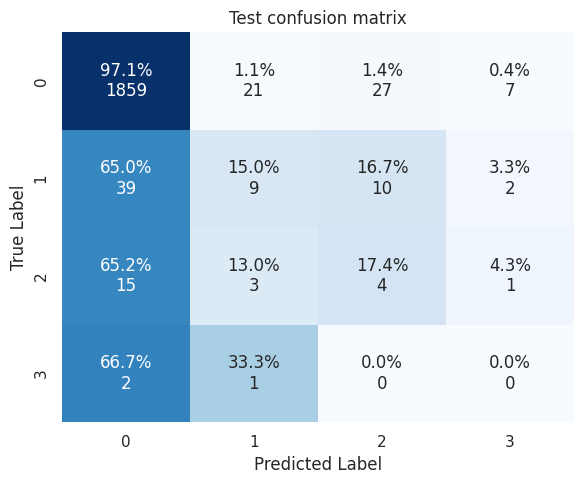

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
pipeline.fit(X_train, y_train)
y_train_pred = pipeline.predict(X_train)
y_test_pred = pipeline.predict(X_test)
display_metrics(y_train, y_train_pred,mode = 'Train')
display_metrics(y_test, y_test_pred,mode = 'Test')

In [ ]:
# checking lifts, lift = precision/probability in the population
classes = y_test.unique()
y_test_pred
for c in classes:
    true_positives = np.sum((y_test == c) & (y_test_pred == c))
    false_positives = np.sum((y_test != c) & (y_test_pred == c))
    precision = true_positives / (true_positives + false_positives)
    lift =precision/(y_test == c).mean()
    print(f"Class {c}: Lift = {lift:.2f}")

Class 0: Lift = 1.01
Class 1: Lift = 8.82
Class 2: Lift = 8.48
Class 3: Lift = 0.00


In [ ]:
importance = pipeline['clf'].feature_importances_

In [ ]:
importance_df = pd.DataFrame({'Feature': X.columns, 'Importance': importance})
importance_df = importance_df.sort_values(by='Importance', ascending=False)


In [ ]:
importance_df.head(10)
# get 10 of the most prominent data

,Feature,Importance
85,risk_factor_feature_7,0.131526
86,risk_factor_feature_8,0.075830
8,lab_papp_a_abs_last_value,0.045782
31,measure_blood_pressure_sys_max_val,0.044944
30,measure_blood_pressure_dias_last_before_last_p...,0.042450
9,lab_papp_a_MoM_last_value,0.039862
26,measure_blood_pressure_dias_max_val,0.036691
27,measure_blood_pressure_dias_min_val,0.033616
35,measure_blood_pressure_sys_last_before_last_pe...,0.030599
18,lab_Platelets (PLT)_last_value,0.027166


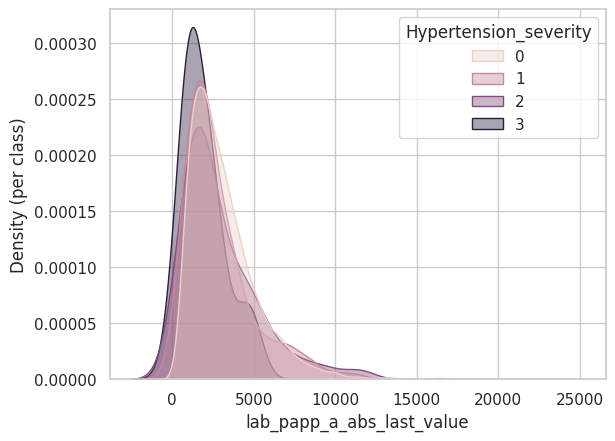

In [ ]:
plot_continuous_varible(df, ['lab_papp_a_abs_last_value'],target_col = 'Hypertension_severity')

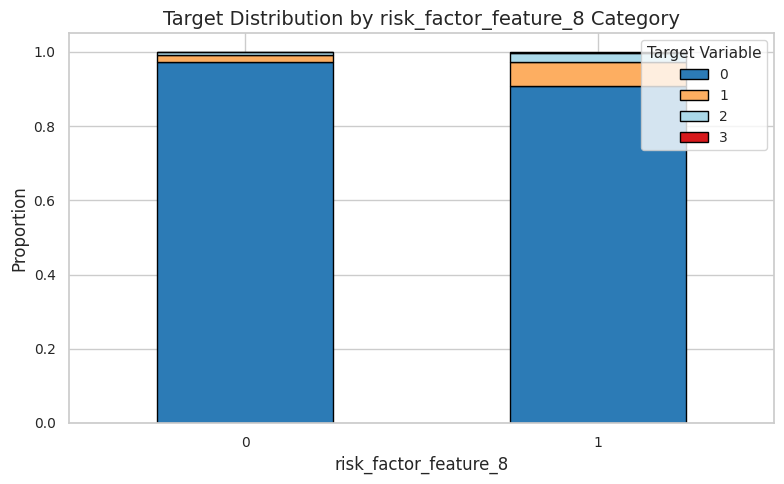

In [ ]:
plot_categorical_varible(df,'risk_factor_feature_8',target_col='Hypertension_severity')

In [ ]:
def screening(allocation_df,budget_percent):
    # priorizting patients for medical check
    population = allocation_df.shape[0]
    budget = int(budget_percent * population)  # num of patients that can take the check
    # Initialize a column to track allocated patients
    allocation_df['allocated_test'] = False

    allocated_count = 0 # Keep track of how many patients have been allocated

    # Iterate through severity classes from most severe (3) to less severe (1)
    for c in [3, 2, 1,0]:
        if allocated_count >= budget:
            break

        # Get indices of patients predicted to be in the current severity class
        patients_in_class = allocation_df[allocation_df['Predicted'] == c].index

        if len(patients_in_class) > 0:

            can_allocate = budget - allocated_count

            # Sort patients in the current class by their probability of being in that class
            # and select the top 'can_allocate' patients' indices
            patients_to_allocate_indices = allocation_df.loc[patients_in_class].sort_values(
                by=f'class_{c}', ascending= False if c>0 else True
            ).head(can_allocate).index



            # Mark these patients as allocated
            allocation_df.loc[patients_to_allocate_indices, 'allocated_test'] = True


            allocated_count += len(patients_to_allocate_indices)


    return allocation_df, allocated_count

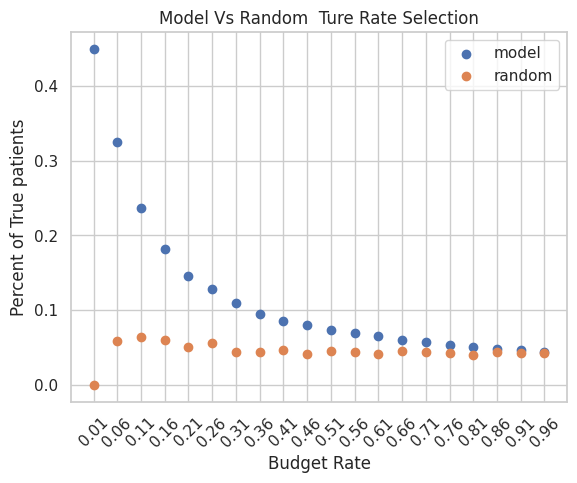

In [ ]:
## preparing data for screening:
# data includes test data- Truth, predictions and probabilities
probabilites = pipeline.predict_proba(X_test)
prob_df = pd.DataFrame(probabilites,columns=['class_0','class_1','class_2','class_3'])
test_df = pd.DataFrame({'True':y_test.values,'Predicted':y_test_pred})
allocation_df = pd.concat([test_df,prob_df],axis=1)
budget_percent = np.arange(0.01,1.01,0.05)
perceived_rate=[]
random_rate = []
for percent in budget_percent:
  allocation_df, patients_allocated_count = screening(allocation_df,percent)
  correctly_allocated =((allocation_df['allocated_test']==True) &( allocation_df['True']>0)).sum()
  perceived_rate.append(correctly_allocated/patients_allocated_count)
  # randomly selected  patients
  random_df = allocation_df.sample(int(percent*allocation_df.shape[0]))
  correctly_allocated =( random_df['True']>0).sum()
  random_rate.append(correctly_allocated/random_df.shape[0])

# compare the rates of True severe patients rate compared to the rate with random selection
plt.scatter(np.arange(len(perceived_rate)),perceived_rate,label = 'model')
plt.scatter(np.arange(len(random_rate)),random_rate,label= 'random')
budget_percent_ticks = [str(round(value,3))for value in budget_percent ]
plt.xticks(np.arange(len(budget_percent)),budget_percent_ticks,rotation=45)
plt.legend()
plt.title('Model Vs Random  Ture Rate Selection')
plt.xlabel('Budget Rate')
plt.ylabel('Percent of True patients')
plt.savefig('model_vs_random.png', dpi=300)
plt.show()
plt.close()